In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib import rcParams 
import cartopy, cartopy.crs as ccrs 
import bdeck as bdeck 
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from helper import thetae, thetaes, greatCircle
import cmaps 

RES = 0.015

dataset = xr.open_mfdataset(r"C:\Users\deela\Downloads\melissa_20251028U1.nc")
print(dataset, list(dataset.variables))

lat = dataset['LAT']
lon = dataset['LON']
tmp = dataset['TA'] + 273.15
dpt = dataset['TD'] + 273.15
prs = dataset['CSP']
slp = dataset['SLP']
vvl = dataset['VV']
uwd = dataset['WSpd_u']
vwd = dataset['WSpd_v']
ga = dataset['GA']
wnd = (uwd**2 + vwd**2)**0.5

thte = thetae(tmp, prs, 1000, dpt, dew = True)
thts = thetaes(tmp, prs, 1000)

<xarray.Dataset> Size: 19MB
Dimensions:   (Time: 22071)
Coordinates:
  * Time      (Time) datetime64[ns] 177kB 2025-10-28T09:57:07 ... 2025-10-28T...
Data variables: (12/49)
    ADR       (Time) float64 177kB dask.array<chunksize=(22071,), meta=np.ndarray>
    AOA       (Time) float64 177kB dask.array<chunksize=(22071,), meta=np.ndarray>
    BCA       (Time) int64 177kB dask.array<chunksize=(22071,), meta=np.ndarray>
    BSP       (Time) float64 177kB dask.array<chunksize=(22071,), meta=np.ndarray>
    CAS       (Time) int64 177kB dask.array<chunksize=(22071,), meta=np.ndarray>
    CSP       (Time) float64 177kB dask.array<chunksize=(22071,), meta=np.ndarray>
    ...        ...
    AVAPS     (Time) int64 177kB dask.array<chunksize=(22071,), meta=np.ndarray>
    DDPH      (Time) int64 177kB dask.array<chunksize=(22071,), meta=np.ndarray>
    1553      (Time) <U44 4MB dask.array<chunksize=(22071,), meta=np.ndarray>
    SFMR      (Time) int64 177kB dask.array<chunksize=(22071,), meta=np.n

In [2]:
t = np.datetime64('2025-10-28T12:35:51')
tElapsed = dataset['Time'] - t
tHours = tElapsed.dt.total_seconds() / 3600
nLat = 17.538 + (0.140 * tHours)
nLon = -78.080 + (0.032 * tHours)

dist = greatCircle(nLat, nLon, lat, lon)
latDistT = lat - nLat 
lonDistT = lon - nLon
print(dist)


<xarray.DataArray (Time: 22071)> Size: 177kB
dask.array<mul, shape=(22071,), dtype=float64, chunksize=(22071,), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) datetime64[ns] 177kB 2025-10-28T09:57:07 ... 2025-10-28T1...


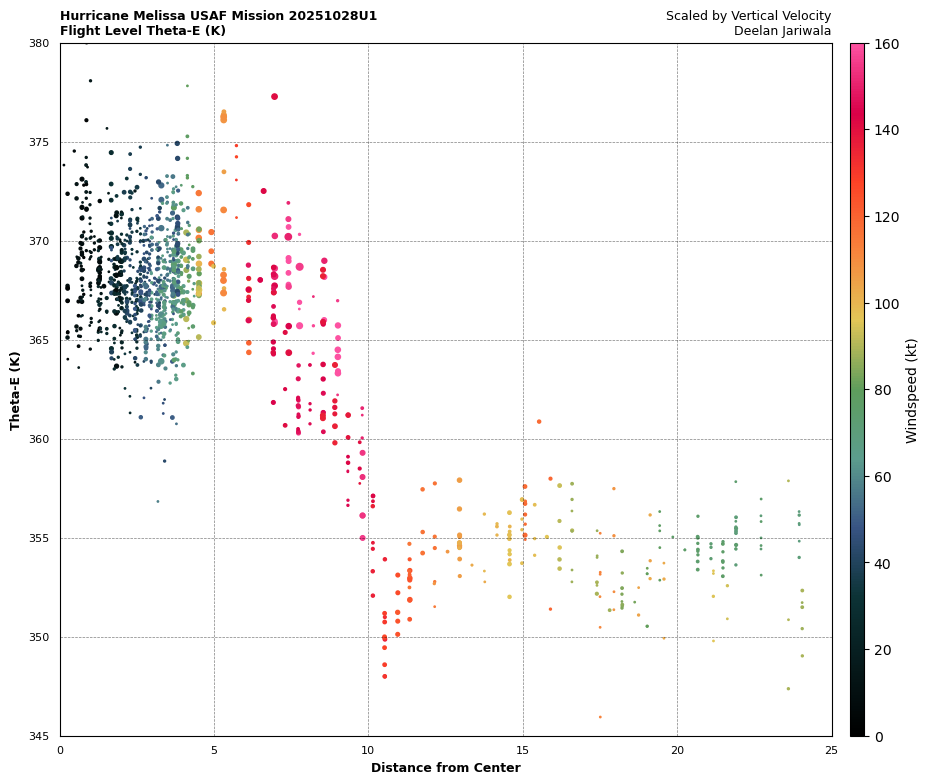

In [59]:
fig = plt.figure(figsize = (12, 9))
ax = plt.axes()

# ax.set_frame_on(False)

ax.tick_params(axis='both', labelsize=8, left = False, bottom = False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_ylabel('Theta-E (K)', weight = 'bold', size = 9)
ax.set_xlabel('Distance from Center', weight = 'bold', size = 9)
# if np.nanmax(anad[:, 1:]) > 0 and np.nanmin(anad[:, 1:]) < 0:
    # ax.axhline(0, linewidth = 2, color = '#000000')
# ax.axvline(0, linewidth = 2, color = '#000000')
ax.set_xlim(0, 25)
ax.set_ylim(345, 380)

# ax.plot(dist, thte, linewidth = 1.5, color = "#CA3232")
c = ax.scatter(dist, thte, c = wnd, s = vvl, cmap = cmaps.probs4(), vmin = 0, vmax = 160)

cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02)
cbar.set_label('Windspeed (kt)')

ax.set_title(f'Hurricane Melissa USAF Mission 20251028U1\nFlight Level Theta-E (K)', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'Scaled by Vertical Velocity\nDeelan Jariwala', fontsize=9, loc='right')
# plt.savefig(r"C:\Users\deela\Downloads\melThetaeTS.png", dpi = 300, bbox_inches = 'tight')
plt.show()


In [4]:
def makeMap(figsize, extent, interval = 5):
    labelsize = 8
    fig = plt.figure(figsize = figsize)

    # Add the map and set the extent
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_frame_on(False)
    
    # Add state boundaries to plot
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth = 0.5, edgecolor = '#cccccc')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth = 0.5, edgecolor = '#cccccc')
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth = 0.5, edgecolor = '#cccccc')
    ax.set_xticks(np.arange(extent[0], extent[1], interval), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(extent[2], extent[3], interval), crs=ccrs.PlateCarree())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.tick_params(axis='both', labelsize=labelsize, left = False, bottom = False)
    ax.grid(linestyle = '--', alpha = 0.5, color = "#767676", linewidth = 0.5, zorder = 12)
    # ax.set_extent(extent, crs=ccrs.PlateCarree())

    return ax

In [5]:
def gridData(data, sLat, sLon, s = 5, res = 1):
    print(data.shape)
    lats = np.arange(sLat - s, sLat + s, res)
    lons = np.arange(sLon - s, sLon + s, res)
    grid = np.meshgrid(lats, lons, indexing = 'ij')

    us = []
    for x in range(len(lats)):
        for y in range(len(lons)):
            u = []
            for z in range(len(data)):
                try:
                    if data[z][0] > lats[x] and data[z][0] < lats[x + 1] and data[z][1] > lons[y] and data[z][1] < lons[y + 1]:
                        u.append(data[z][2:]) 
                    else:
                        u.append([np.nan for x in range(data.shape[1] - 2)])
                except:
                        u.append([np.nan for x in range(data.shape[1] - 2)])
            us.append(u)
    us = np.nanmean(us, axis = 1)

    return grid, np.array(us).reshape(grid[0].shape + (-1,))


In [6]:
varNames = ['temperature', 'dewpoint', 'pres_alt', 'slp', 'vert_vel', 'uwnd', 'vwnd', 'fl_wspd', 'thetae', 'gpt_height']
clat = 17.58
clon = -78.06
(lats, lons), allData = gridData(np.array([lat, lon, tmp, dpt, prs, slp, vvl, uwd, vwd, wnd, thte, ga]).T, clat, clon, s = 0.1, res = RES)
(latDist, lonDist), allDataC = gridData(np.array([latDistT, lonDistT, tmp, dpt, prs, slp, vvl, uwd, vwd, wnd, thte, ga]).T, 0, 0, s = 0.1, res = RES)

(22071, 12)


C:\Users\deela\AppData\Local\Temp\ipykernel_17016\694048962.py:20: RuntimeWarning: Mean of empty slice
  us = np.nanmean(us, axis = 1)


(22071, 12)


<xarray.Dataset> Size: 32kB
Dimensions:       (lat: 14, lon: 14, lat_dist: 14, lon_dist: 14)
Coordinates:
  * lat           (lat) float64 112B 17.48 17.49 17.51 ... 17.65 17.66 17.68
  * lon           (lon) float64 112B -78.16 -78.14 -78.13 ... -77.98 -77.96
    latDist       (lat_dist) float64 112B -0.1 -0.085 -0.07 ... 0.065 0.08 0.095
    lonDist       (lon_dist) float64 112B -0.1 -0.085 -0.07 ... 0.065 0.08 0.095
Dimensions without coordinates: lat_dist, lon_dist
Data variables: (12/20)
    temperature   (lat, lon) float64 2kB nan nan nan nan nan ... nan nan nan nan
    dewpoint      (lat, lon) float64 2kB nan nan nan nan nan ... nan nan nan nan
    pres_alt      (lat, lon) float64 2kB nan nan nan nan nan ... nan nan nan nan
    slp           (lat, lon) float64 2kB nan nan nan nan nan ... nan nan nan nan
    vert_vel      (lat, lon) float64 2kB nan nan nan nan nan ... nan nan nan nan
    uwnd          (lat, lon) float64 2kB nan nan nan nan nan ... nan nan nan nan
    ...           

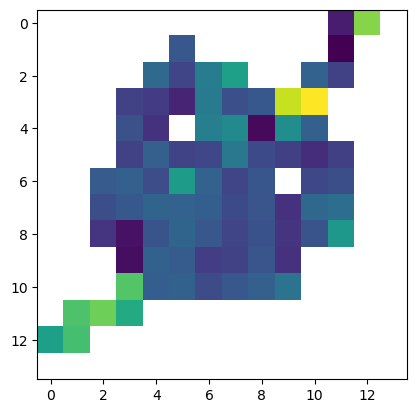

In [7]:
Ny, Nx = allData.shape[0], allData.shape[1]

ds = xr.Dataset(coords=dict(
    lat=(("lat"), lats[:,0]),
    lon=(("lon"), lons[0,:]),
    latDist = (("lat_dist", latDist[:, 0])),
    lonDist = (("lon_dist", lonDist[0, :]))
))

# Loop through your 9 variables
for i, name in enumerate(varNames):
    ds[name] = (("lat", "lon"), allData[:, :, i])

for i, name in enumerate(varNames):
    ds[f'C{name}'] = (("lat_dist", "lon_dist"), allDataC[:, :, i])

ds.to_netcdf(r"C:\Users\deela\Downloads\melissaGriddedData_20251028U1" + str(RES) + ".nc")
print(ds)
plt.imshow(ds['Cvert_vel'])
plt.show()

In [8]:
import numpy as np

R = 6371000.0  

latr = np.deg2rad(lats)
lonr = np.deg2rad(lons)

dlat = np.gradient(latr, axis=0)   
dlon = np.gradient(lonr, axis=1)

dx = R * np.cos(latr) * dlon   
dy = R * dlat                  

du_dy, du_dx = np.gradient(ds['uwnd']) 
dv_dy, dv_dx = np.gradient(ds['vwnd'])

fxx = du_dx / dx
fxy = du_dy / dy
fyx = dv_dx / dx
fyy = dv_dy / dy

vort = fyx - fxy
div = fxx + fyy

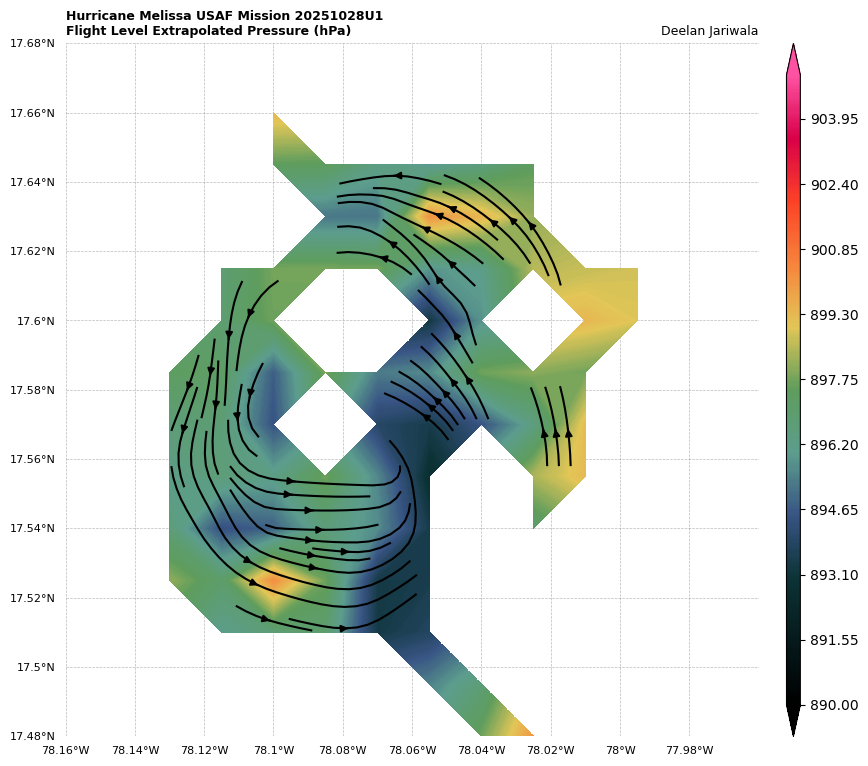

In [9]:
ax = makeMap((18, 9), extent = [clon - 0.1, clon + 0.1, clat - 0.1, clat + 0.1], interval = .02)
ax.set_extent([clon - 0.1, clon + 0.1, clat - 0.1, clat + 0.1])

ax.set_title(f'Hurricane Melissa USAF Mission 20251028U1\nFlight Level Extrapolated Pressure (hPa)', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'Deelan Jariwala', fontsize=9, loc='right')

ax.streamplot(lons, lats, ds['uwnd'], ds['vwnd'], color = 'black', density = 2, zorder = 15, transform=ccrs.PlateCarree())
# c = ax.contourf(grid[1], grid[0], dat, cmap = cmaps.probs4(), levels = np.arange(0, 80.5, .5), extend = 'both', zorder = 10)
c = ax.contourf(lons, lats, ds['slp'], cmap = cmaps.probs4(), levels = np.arange(890, 905.05, .05), extend = 'both', zorder = 10)

cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02)
# plt.savefig(r"C:\Users\deela\Downloads\melSLP.png", dpi = 400, bbox_inches = 'tight')
plt.show()

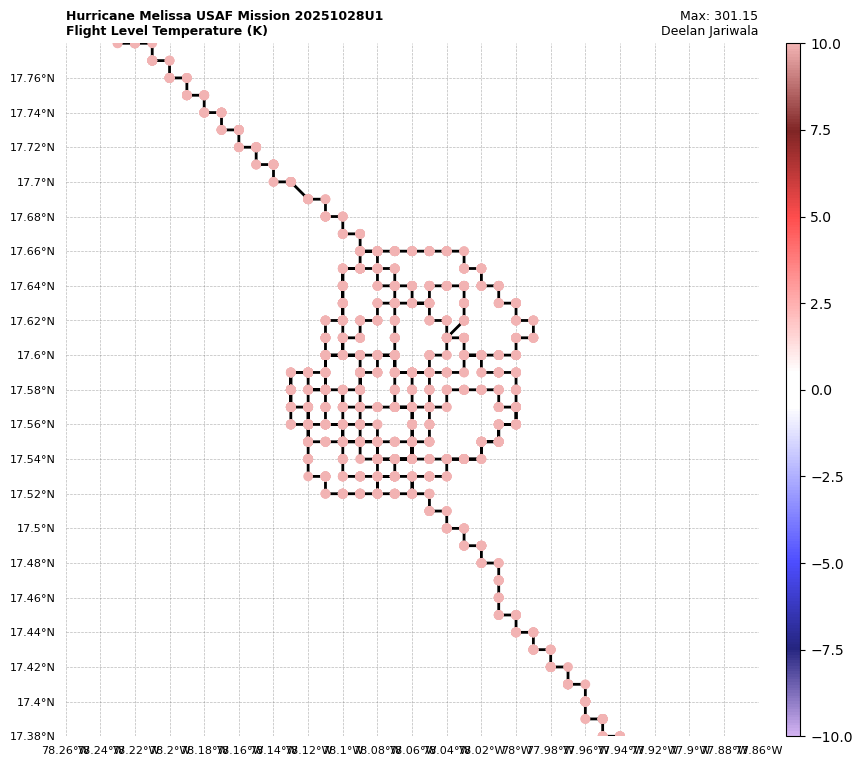

In [10]:
ax = makeMap((18, 9), extent = [clon - 0.2, clon + 0.2, clat - 0.2, clat + 0.2], interval = .02)
ax.set_extent([clon - 0.2, clon + 0.2, clat - 0.2, clat + 0.2])

ax.set_title(f'Hurricane Melissa USAF Mission 20251028U1\nFlight Level Temperature (K)', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'Max: {round(np.nanmax(tmp), 2)}\nDeelan Jariwala', fontsize=9, loc='right')

c = ax.scatter(lon, lat, c = tmp, cmap = cmaps.tempAnoms3(), vmin = -10, vmax = 10, zorder = 15)
ax.plot(lon, lat, color = 'black', linewidth = 2, zorder = 10)

cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02)
# plt.savefig(r"C:\Users\deela\Downloads\melThetaE.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [26]:
nuData, nvData = ds['Cuwnd'].values, ds['Cvwnd'].values

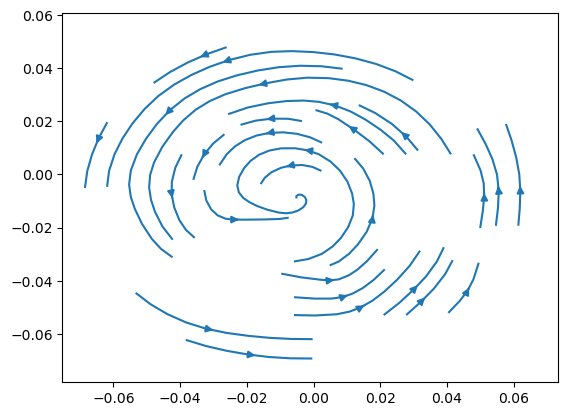

In [12]:
plt.streamplot(lonDist, latDist, nuData, nvData)
plt.show()

In [27]:
import numpy as np

def subtract_spiral(u, v, x, y, x0, y0, n_r_bins=60, r_min_frac=0.0, r_max_frac=1.0):
    """
    Subtract an axisymmetric spiral (radial + tangential mean) from a 2D vector field.

    Parameters
    ----------
    u, v : 2D arrays (ny, nx)
        Vector components.
    x, y : 2D arrays (ny, nx)
        Coordinate grids (Cartesian: same units, e.g. km or m).
    x0, y0 : float
        Center of the spiral in the same units as x, y.
    n_r_bins : int
        Number of radial bins used to compute the azimuthal mean.
    r_min_frac, r_max_frac : float
        Fraction of [0, r_max] over which to fit the spiral (to ignore very center/noisy outer edge).

    Returns
    -------
    u_prime, v_prime : 2D arrays
        Vector field with the spiral removed.
    U_spiral, V_spiral : 2D arrays
        The reconstructed spiral that was subtracted.
    """

    # 1. Polar coordinates relative to center
    dx = x - x0
    dy = y - y0
    r = np.sqrt(dx**2 + dy**2)
    theta = np.arctan2(dy, dx)  # [-pi, pi]

    # 2. Convert (u, v) -> (ur, ut)
    ur =  u * np.cos(theta) + v * np.sin(theta)
    ut = -u * np.sin(theta) + v * np.cos(theta)

    # 3. Radial bins
    r_flat = r.ravel()
    ur_flat = ur.ravel()
    ut_flat = ut.ravel()

    # Mask NaNs early
    good = np.isfinite(r_flat) & np.isfinite(ur_flat) & np.isfinite(ut_flat)

    r_flat = r_flat[good]
    ur_flat = ur_flat[good]
    ut_flat = ut_flat[good]

    if r_flat.size == 0:
        raise ValueError("No valid points to compute spiral from.")

    r_max = r_flat.max()
    r_min = 0.0

    # Optionally ignore center or outer noisy region
    r_min = r_min_frac * r_max
    r_max_use = r_max_frac * r_max

    # Bin edges
    r_edges = np.linspace(r_min, r_max_use, n_r_bins + 1)
    r_centers = 0.5 * (r_edges[:-1] + r_edges[1:])

    # 4. Azimuthal means in each radial bin
    ur_mean = np.full_like(r_centers, np.nan, dtype=float)
    ut_mean = np.full_like(r_centers, np.nan, dtype=float)

    for i in range(n_r_bins):
        in_bin = (r_flat >= r_edges[i]) & (r_flat < r_edges[i+1])
        if np.any(in_bin):
            ur_mean[i] = np.nanmean(ur_flat[in_bin])
            ut_mean[i] = np.nanmean(ut_flat[in_bin])

    # 5. Interpolate radial profile back onto full r-field
    #    (points outside [r_min, r_max_use] get NaN -> spiral=0 there)
    ur_axisym = np.interp(r, r_centers, ur_mean, left=np.nan, right=np.nan)
    ut_axisym = np.interp(r, r_centers, ut_mean, left=np.nan, right=np.nan)

    # 6. Reconstruct axisymmetric spiral in Cartesian components
    U_spiral = ur_axisym * np.cos(theta) - ut_axisym * np.sin(theta)
    V_spiral = ur_axisym * np.sin(theta) + ut_axisym * np.cos(theta)

    # If you want: treat NaNs (unfitted region) as zero spiral
    U_spiral = np.where(np.isfinite(U_spiral), U_spiral, 0.0)
    V_spiral = np.where(np.isfinite(V_spiral), V_spiral, 0.0)

    # 7. Subtract
    u_prime = u - U_spiral
    v_prime = v - V_spiral

    return u_prime, v_prime, U_spiral, V_spiral

# Get gridded u, v
latGrid, lonGrid = latDist, lonDist  # your grid output

# Convert to local Cartesian (km)
R = 6371.0
cphi = np.cos(np.radians(clat))

x = R * np.radians(lonGrid - 0) * cphi
y = R * np.radians(latGrid - 0)

# Compute perturbation field
u_prime, v_prime, U_spiral, V_spiral = subtract_spiral(
    nuData, nvData,
    x, y,
    x0=0, y0=0,          # center is already zero
    n_r_bins=60,         # number of radial bins (adjust)
    r_min_frac=0.05,     # ignore noisy center if needed
    r_max_frac=0.95      # ignore extreme edge if needed
)

In [28]:
import numpy as np

R = 6371000.0  

latr = np.deg2rad(latDist)
lonr = np.deg2rad(lonDist)

dlat = np.gradient(latr, axis=0)   
dlon = np.gradient(lonr, axis=1)

dx = R * np.cos(latr) * dlon   
dy = R * dlat                  

du_dy, du_dx = np.gradient(u_prime) 
dv_dy, dv_dx = np.gradient(v_prime)

fxx = du_dx / dx
fxy = du_dy / dy
fyx = dv_dx / dx
fyy = dv_dy / dy

vortC = fyx - fxy
divC = fxx + fyy

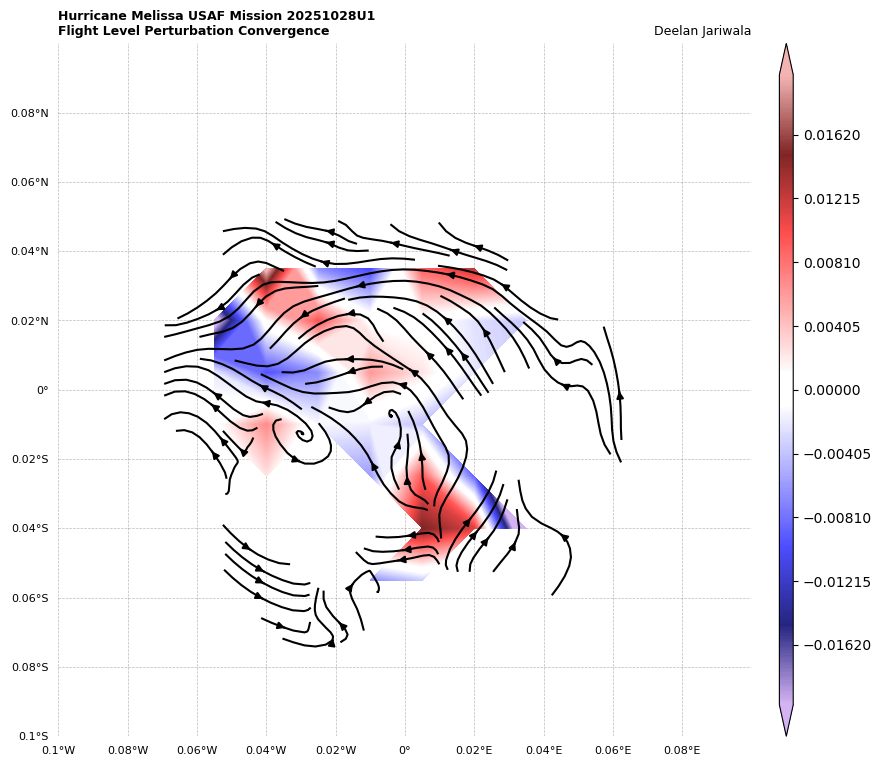

In [29]:
clon = clat = 0 
ax = makeMap((18, 9), extent = [clon - 0.1, clon + 0.1, clat - 0.1, clat + 0.1], interval = .02)
ax.set_extent([clon - 0.1, clon + 0.1, clat - 0.1, clat + 0.1])

ax.set_title(f'Hurricane Melissa USAF Mission 20251028U1\nFlight Level Perturbation Convergence', fontweight='bold', fontsize=9, loc='left')
ax.set_title(f'Deelan Jariwala', fontsize=9, loc='right')

# grid, dat = gridData(np.array([slp, latDist, lonDist]).T, clat, clon, s = 0.1, res = 0.015)

# print(np.nanmin(dat), np.nanmax(dat), np.nanmean(dat))
ax.streamplot(lonDist, latDist, u_prime, v_prime, color = 'black', density = 2, zorder = 15, transform=ccrs.PlateCarree())
c = ax.contourf(lonDist, latDist, divC, cmap = cmaps.tempAnoms3(), levels = np.arange(-.02, .02 + .00005, .00005), extend = 'both', zorder = 10)
# c = ax.pcolormesh(grid[1], grid[0], dat, cmap = cmaps.probs4(), vmin = 365, vmax = 375, zorder = 10)

cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02)
# plt.savefig(r"C:\Users\deela\Downloads\pertConvMel.png", dpi = 400, bbox_inches = 'tight')
plt.show()

In [69]:
t = 30
d = 14
p = 700
print(thetae(t + 273.15, p, 1000, d + 273.15))

377.5241244822633
